This notebook will estimate the full-scale voltage of the Fireface 802 sound card. 

### What was done 
A signal analyser (KEYSIGHT InfiniiVision DSO-X 2004A) was used to output a sinusoidal wave at 1kHz at different peak-to-peak (p2p) amplitudes in this order: 0.25, 0.5, 1, 2, 1.9, 1.75, 1.5 Volts p2p.

The BNC out from the signal analyser was connected to channel 9 of the soundcard, through a BNC cable with a BNC-instrument jack adapter. A 75 Ohm impedance BNC cable was used of ~2m length.

The gain on channel 9 was constant at +30 dB. 


The Fireface 802 in hand has the serial number: 23746770 (behind next to line in jacks). To be sure of my measurement approach, I also [repeated some measurements on another Fireface 802](#dev2) that was in the lab.

-- Thejasvi Beleyur, 19th April 2021

### What is known (2021-04-20)

I initially got the impression the full-scale (FS) voltage was something that wasn't in the [user's manual](https://archiv.rme-audio.de/download/fface_802_e.pdf). But it actually is! So, as usual, there's something interesting happening here (all on pg 96). 

1. The front inputs have different FS voltages depending on XLR or Instrument inputs. 
    * Front with XLR input, the max input level @Lo gain is 10 +6dB gain -> 16dBu 
    * Front with Instrument input, the max input level @Lo gain is 21+6 dB gain -> 27 dBu
1. The back inputs have a different FS voltage than the front. 
    * Each input at the back has: 19 dBu max level 
    
The unit dBu is a decibel unit with the reference set to 0.775V. Let's convert everything to Vpp, and see if the numbers match up. This [section](#verifying) takes us to the end of the notebook where we'll do some double checking. 

### To Do:

* Measure full-scale Vpp of line-ins at the back 
* Measure full-scale Vpp of signal fed through the XLR.


In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np 
import scipy.signal as signal 
import scipy.stats as stats
import soundfile as sf
from fullscale_calculations import * 

In [2]:
print(f' Start time notebook: {dt.datetime.now()}')

 Start time notebook: 2021-04-20 18:53:19.911522


In [3]:
dB = lambda X: 20*np.log10(abs(X))
def get_peak_2_peak(X):
    return np.max(X)-np.min(X)
def db_p2p_re2(X):
    return dB(get_peak_2_peak(X)/2.0)

In [4]:
%matplotlib notebook

In [5]:
audio_file = 'full_scale_fireface802/1kHz_fullscale_calibration.wav'
audio,fs = sf.read(audio_file)

The voltages between 1.75-2 p2p were saturating the soundcard, and so we'll ignore those readings. So, we have 0.25, 0.5, 1, 1.5 V p2p measurements. 

In [6]:
times = [(0,3.0), (4.3,6.8), (8.3,10.6), (25.1, 28.0)] # start and stop times in seconds 
rec_parts = []
for (start, stop) in times:
    start_ind, stop_ind = int(start*fs), int(stop*fs)
    rec_parts.append(audio[start_ind:stop_ind])

In [7]:
v_p2p = np.array([0.25, 0.5, 1.0, 1.5])
dbp2pre2 = np.array([db_p2p_re2(each) for each in rec_parts])
gain = 30 # dB 
dbp2pre2_wogain = dbp2pre2-30
dbp2pre2_wogain

array([-46.65436741, -40.63466922, -34.65565029, -31.10563076])

<IPython.core.display.Javascript object>


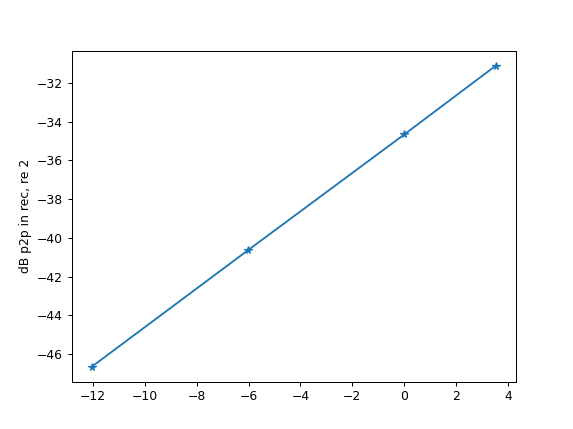

Text(0, 0.5, 'dB p2p in rec, re 2')

In [8]:
plt.figure()
plt.plot(dB(v_p2p), dbp2pre2_wogain, '-*')
plt.ylabel('dB p2p in rec, re 2')

In [9]:
# make a linear model to get the value at saturation
slope, intcpt, r_value, p_value, stderr = stats.linregress(dB(v_p2p),dbp2pre2_wogain)
print(f'slope:{slope} dB p2p increase per dB p2p V increase')
print(f'intercept:{intcpt} dB p2p ')
print(stderr)

slope:0.9981920958050732 dB p2p increase per dB p2p V increase
intercept:-34.63415749944877 dB p2p 
0.001596895207142517


In [10]:
10**(34.6/20)

53.70317963702527

In [11]:
10**(34.6/20)

53.70317963702527

In [12]:
53.7*0.5

26.85

This implies the full-scale voltage of the Fireface 802 is 53.7 V. So, at 0dB gain, a voltage of 26.85p2p should give rise to -6dB p2p re 2 level. Let's check this. 

### 5V p2p at 6 dB gain:
I also did a separate recording with 6dB gain from channel 9 to check if the full-scale estimate makes sense. 

In [13]:
nogain_audio, fs = sf.read('full_scale_fireface802/1kHz_5V_nogain_fullscale_calibration.wav')
nogain5v_dbp2p = db_p2p_re2(nogain_audio)-6
nogain5v_dbp2p

-20.349805824450435

So if 5V is ~-20.3 dB p2p re2, then the full scale (0dB p2p re2) is ~50 V only. Now, let's add all the points together and get the estimate. 

In [14]:
dbp2pre2_wogain = np.concatenate((dbp2pre2_wogain, np.array([nogain5v_dbp2p])))
v_dbp2p = dB(np.concatenate((v_p2p, np.array([5.0]))))

<IPython.core.display.Javascript object>


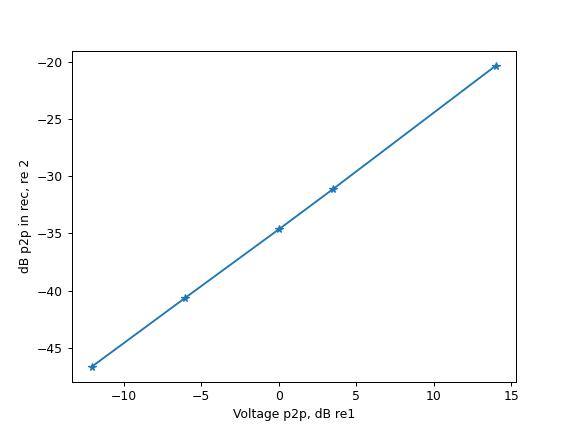

Text(0.5, 0, 'Voltage p2p, dB re1')

In [15]:
plt.figure()
plt.plot(v_dbp2p, dbp2pre2_wogain, '-*')
plt.ylabel('dB p2p in rec, re 2');plt.xlabel('Voltage p2p, dB re1')

In [16]:
# make a linear model to get the value at saturation
slope, intcpt, r_value, p_value, stderr = stats.linregress(v_dbp2p,dbp2pre2_wogain)
print(f'slope:{slope} dB p2p increase per dB p2p V increase')
print(f'intercept:{intcpt} dB p2p ')
print(stderr)

slope:1.0101544220518308 dB p2p increase per dB p2p V increase
intercept:-34.56677134363736 dB p2p 
0.005260283549961651


And so, now we have the equation: $y = mx + c$, where:
* $y$ is the observed dB p2p level
* $m$ is the dB change in rec. level with dB change in signal level
* $x$ is the p2p voltage in dB re 1V
* $c$ is the observed dB p2p level at  0 dB re 1V. 

To find the point at which the observed level will be full scale (0 dB), we just set the $0 = mx +c$, which then becomes: $x = -c/m$, and so with this, let's substitute:


In [17]:
full_scale = -intcpt/slope
print(full_scale)

34.21929418813528


In Volts p2p 34.2 dB is: 

In [18]:
10**(full_scale/20)

51.40018823011477

The full-scale of the Fireface 802 is 51.4 Volts peak 2 peak (footnote). This seems to be a weird-ish number, my suspicion is however that in reality, the full-scale is a nice round 50V? Either way, for now, this is a good enough estimate. 


<a id='dev2'></a>
### Corroborating the full-scale voltage from another Fireface 802 device. 
Here too I used the same physical setup to check the FS Voltage (p2p) using another piece of the same model (sr. no. 23714283).

In [19]:
voltages = np.array([5,2.5,1.25,0.5, 0.25, 0.125, 0.05])
stsop_times  = [(0.2,2.0), (3.15,5.0),
                (7.96,9.6), (12.02,14.22),
                (15.4, 16.96), (17.57, 19.25),
                (20.53, 22.9)]
another_audio ,fs = sf.read('full_scale_fireface802/nonushichka_ff802_1khzcalib.wav')
another_audio = another_audio[:,0]
audio_parts = []
for (start,stop) in stsop_times:
    audio_parts.append(another_audio[int(start*fs):int(stop*fs)])
    

In [20]:
# measure the dB p2pre2
another_dbp2pre2 = []
for each in audio_parts:
    another_dbp2pre2.append(db_p2p_re2(each)-6)

<IPython.core.display.Javascript object>


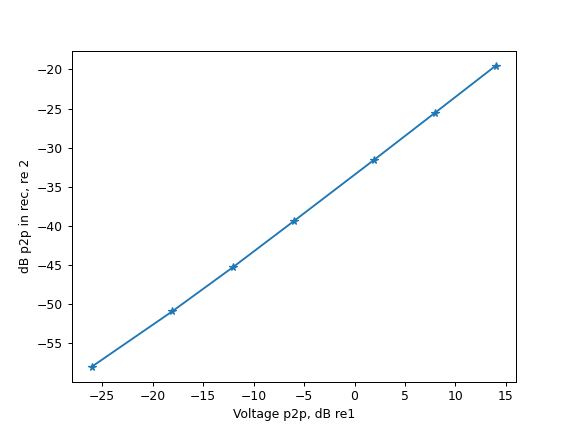

Text(0.5, 0, 'Voltage p2p, dB re1')

In [21]:
plt.figure()
plt.plot(dB(voltages),another_dbp2pre2,'-*')
plt.ylabel('dB p2p in rec, re 2');plt.xlabel('Voltage p2p, dB re1')

Run the regression now. 

In [22]:
# make a linear model to get the value at saturation
slope, intcpt, r_value, p_value, stderr = stats.linregress(dB(voltages),np.array(another_dbp2pre2))
print(f'slope:{slope} dB p2p increase per dB p2p V increase')
print(f'intercept:{intcpt} dB p2p ')
print(stderr)

slope:0.9660087151290585 dB p2p increase per dB p2p V increase
intercept:-33.31911463380436 dB p2p 
0.009063441899257653


and calculat ethe full-scale with $-c/m$

In [23]:
full_scale_dev2 = -intcpt/slope
full_scale_dev2 # dB Voltage p2p re 1

34.49152591687844

In [24]:
10**(full_scale_dev2/20.0)

53.0366758043255

<a id='verifying'></a>
## Verifying with the technical specs

As previously stated:

*1. The front inputs have different FS voltages depending on XLR or Instrument inputs. 
    * Front with XLR input, the max input level @Lo gain is 10 +6dB gain -> 16dBu 
    * Front with Instrument input, the max input level @Lo gain is 21+6 dB gain -> 27 dBu*
    
*2. The back inputs have a different FS voltage than the front. 
    * Each input at the back has: 19 dBu max level*

The technical specs are in dBu, which is a decibel unit with 0.775 Vrms as the reference. To compare with our measurements, we need to thus, convert dBu -> Vrms -> dB Vpp (re 1). 

Now, let's convert dBu to dBVpp and check. 

In [25]:
manual_vp2p = dbu2vp2p(27)
manual_vp2p

49.07346184628759

We expect that the actual FS for the instrument jacks to be 49.07Vpp, but we instead have 51 Vpp and 53 Vpp for the devices measured on channel 9. 

How off are these measurements on a dB scale? 

In [26]:
dev2_vp2p = 10**(full_scale_dev2/20.0)
dev2_vp2p

53.0366758043255

In [27]:
dev1_vp2p = 10**(full_scale/20)
dev1_vp2p

51.40018823011477

#### Full scale dBu of both Fireface 802's:

In [28]:
vpp2dbu(dev1_vp2p), vpp2dbu(dev2_vp2p)

(27.402360268089634, 27.674591996832795)

#### Instrument jacks on ch. 9 show ~27 dBu full scale levels. 

Device #1(used in Ushichka) and #2 have slightly more than (0.67 and 0.40 dB respectively) the 27dBu in the manual. I guess this is overall not so bad. I'd also like to check the levels in the line-in channels, to make sure that it matches.  Even though the difference in full-scale Vpp between devices is ~1.6V, in the dB scale it seems pretty close (<1dB).

What does this inter-device variation mean for measurements taken across multiple devices? It means that some devices may have a slightly lower/higher full-scale. When using multiple devices of the same model, an error of <1 dB may be part of the overall measurement process, eg. if the mic calibration was done on one device, and the actual field work done on another. 

This again kind of highlights the necessity of really keeping the entire experimental setup together during calibrations. 



In [29]:
print(f' End time notebook: {dt.datetime.now()}')

 End time notebook: 2021-04-20 18:53:20.829491
